## Setup

In [1]:
import time
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from utils import *
from q_learning import *
from deep_q_learning import *

In [2]:
# Configurations
save_stats = True
save_figs = True
train = True
load = not train

seed = 0

In [3]:
# Configuration paramaters for the whole setup
#seed = 0

env = TictactoeEnv()

gamma = 0.99
lr = 5e-4
epsilon_min = 0.1
epsilon_max = 0.8
num_episodes = 20000
test_freq = 250
num_avg = 1

## Learning from experts

### Question 11: Average reward and average loss during training

************** RUN 1 OF 1 **************


100%|██████████| 20000/20000 [13:59<00:00, 23.82it/s]


M_opt = 0.0
M_rand = 0.916
RUN 1 took 846.7 seconds
epsilon_exploration_Q11 = 0.1 : 	M_opt =  0.0 	M_rand =  0.916


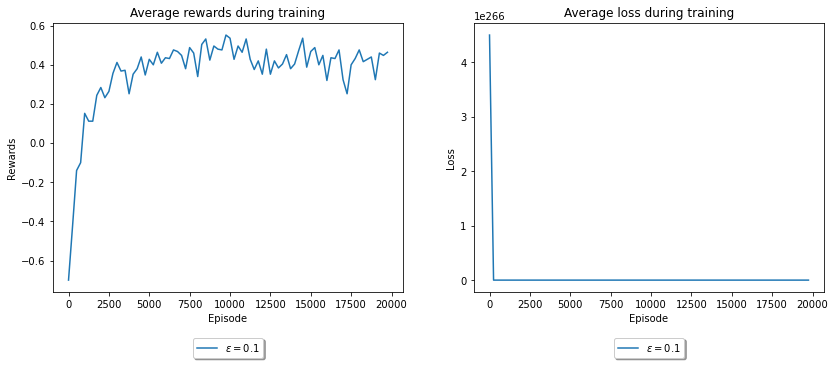

In [22]:
epsilon_exploration = 0.1
stats_dict_list = []
for i in range(num_avg):
    print('************** RUN', i+1, 'OF', num_avg, '**************')
    stats_dict = {}
    start = time.time()
    model, stats = deep_q_learning(env, epsilon_exploration=epsilon_exploration, num_episodes=num_episodes, against_opt=True)
    M_opt = measure_performance(DeepQPlayer(model=model), OptimalPlayer(epsilon=0.))
    M_rand = measure_performance(DeepQPlayer(model=model), OptimalPlayer(epsilon=1.))
    print("M_opt =", M_opt)
    print("M_rand =", M_rand)
    stats_dict.update({epsilon_exploration: (stats, M_opt, M_rand)})
    stats_dict_list.append(stats_dict)
    print('RUN', i+1, 'took', np.round(time.time()-start,decimals=1), 'seconds')

plot_stats(stats_dict_list, [epsilon_exploration], 'epsilon_exploration_Q11', '\epsilon', save=save_figs, keys = ['rewards', 'loss'])

### Question 12: no replay buffer and batch_size = 1

************** RUN 1 OF 1 **************


100%|██████████| 20000/20000 [11:18<00:00, 29.47it/s]


M_opt = 0.0
M_rand = 0.79
RUN 1 took 686.9 seconds
epsilon_exploration_Q11 = 0.1 : 	M_opt =  0.0 	M_rand =  0.79


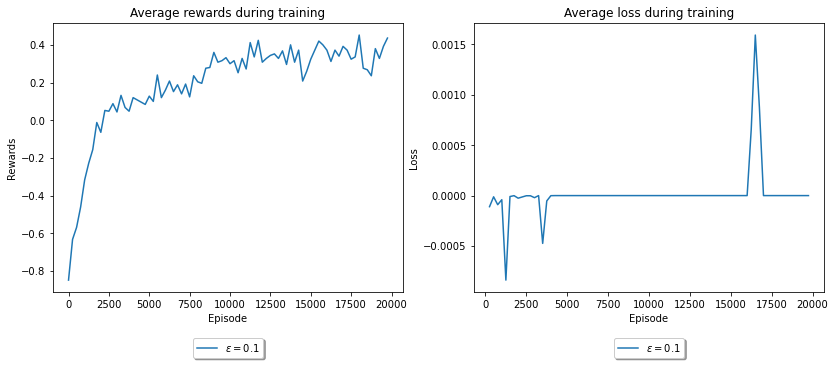

In [23]:
epsilon_exploration = 0.1
stats_dict_list = []
for i in range(num_avg):
    print('************** RUN', i+1, 'OF', num_avg, '**************')
    stats_dict = {}
    start = time.time()
    model, stats = deep_q_learning(env, epsilon_exploration=epsilon_exploration, num_episodes=num_episodes, against_opt=True,
                                   batch_size=1, max_memory_length=1)
    M_opt = measure_performance(DeepQPlayer(model=model), OptimalPlayer(epsilon=0.))
    M_rand = measure_performance(DeepQPlayer(model=model), OptimalPlayer(epsilon=1.))
    print("M_opt =", M_opt)
    print("M_rand =", M_rand)
    stats_dict.update({epsilon_exploration: (stats, M_opt, M_rand)})
    stats_dict_list.append(stats_dict)
    print('RUN', i+1, 'took', np.round(time.time()-start,decimals=1), 'seconds')

plot_stats(stats_dict_list, [epsilon_exploration], 'epsilon_exploration_Q11', '\epsilon', save=save_figs, keys = ['rewards', 'loss'])

### Question 13: Decreasing exploration for different values of $n^{*}$

In [10]:
vec_n_star = np.hstack((np.array([1, 100, 500, 750]), np.round(np.logspace(3, np.log10(40000), 16))))
num_splits = 3
chunks_list = np.array_split(vec_n_star, num_splits)
print(chunks_list)

[array([1.000e+00, 1.000e+02, 5.000e+02, 7.500e+02, 1.000e+03, 1.279e+03,
       1.635e+03]), array([2091., 2674., 3420., 4373., 5593., 7152., 9146.]), array([11696., 14957., 19127., 24460., 31279., 40000.])]


In [11]:
dqn_params_list = []
for (idx, chunk) in enumerate(chunks_list):
    dqn_params_list.append([])
    for n_star in chunk:
        params = {'env': env,
                  'num_episodes': num_episodes,
                  'epsilon_exploration_rule': return_lambda_explor(epsilon_min, epsilon_max, n_star),
                  'test_freq': test_freq,
                  'against_opt': True}
        dqn_params_list[idx].append(params)

In [ ]:
chunk_num = 0
if train:
    var_name = 'dqn_n_star_experts_' + str(chunk_num)
    chunk = chunks_list[chunk_num]
    stats_dict_nstar = train_avg(var_name, chunk, dqn_params_list[chunk_num], dqn = True, num_avg=num_avg, save_stats=save_stats)

In [ ]:
# Merge
stats_dicts = {}
if save_stats:
    stats_dict_nstar_list = []
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    for i in range(len(chunks_list)):
        fname = output_folder + '/stats_dict_dqn_n_star_experts_' + str(i) + '_list.pkl'
        with open(fname, 'rb') as handle:
            stats_dicts.update({i: pickle.load(handle)})
    for i in range(num_avg):
        to_append = {}
        for key in stats_dicts.keys():
            to_append.update(stats_dicts[key][i])
        stats_dict_nstar_list.append(to_append)
    fname = output_folder + '/dqn_stats_dict_nstar_experts_list.pkl'
    with open(fname, 'wb') as handle:
        pickle.dump(stats_dict_nstar_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

dqn_n_star = 1.0 : 	M_opt =  -0.1 	M_rand =  0.836
dqn_n_star = 500.0 : 	M_opt =  -0.114 	M_rand =  0.9
dqn_n_star = 1000.0 : 	M_opt =  0.0 	M_rand =  0.934
dqn_n_star = 9146.0 : 	M_opt =  -0.212 	M_rand =  0.92
dqn_n_star = 19127.0 : 	M_opt =  -0.314 	M_rand =  0.92
dqn_n_star = 40000 : 	M_opt =  -0.19 	M_rand =  0.802


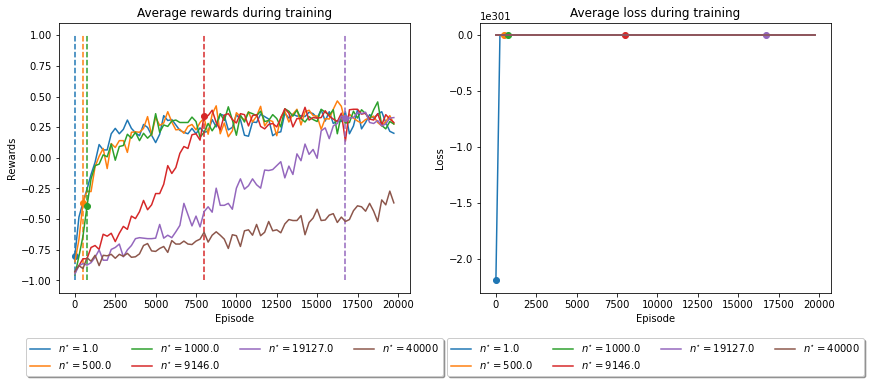

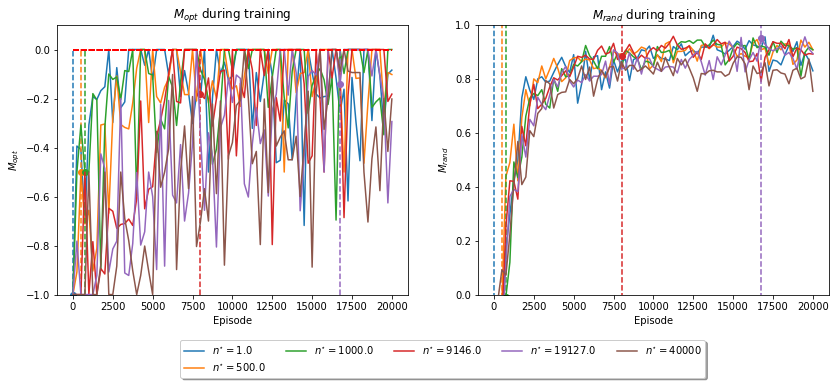

In [18]:
if load:
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/dqn_stats_dict_nstar_experts_list.pkl'
    with open(fname, 'rb') as handle:
        stats_dict_nstar_list = pickle.load(handle)

plot_n_star = [1., 500., 1000., 9146., 19127., 40000]
plot_stats(stats_dict_nstar_list, plot_n_star, 'dqn_n_star', "n^{\star}", save=save_figs, decaying_exploration=True)

### Question 14: Different values of $\epsilon_{\text{opt}}$

In [ ]:
best_n_star = #########
M = 11
vec_epsilon_opt = np.linspace(0, 1, M)
deep_q_learning_params_list = []
var_name = "epsilon_opt_deep"
for eps in vec_epsilon_opt:
    params = {'env': env,
              'num_episodes': num_episodes,
              'epsilon_exploration_rule': return_lambda_explor(epsilon_min, epsilon_max, best_n_star),
              'epsilon_opt': eps,
              'test_freq': test_freq,
              'against_opt': True}
    deep_q_learning_params_list.append(params)

In [ ]:
if train:
    stats_dict_epsilon_opt_list_deep = train_avg(var_name, vec_epsilon_opt, deep_q_learning_params_list, dqn = True,
                                                      num_avg=num_avg, save_stats=True)

### Question 15: Best values of $M_{\text{opt}}$ and $M_{\text{rand}}$

In [ ]:
# TODO

## Learning by self-practice

In [6]:
n_star = 1
def rule(n):
    return max(epsilon_min, epsilon_max*(1-n/n_star))
stats_dict_list = []
for i in range(num_avg):
    print('************** RUN', i+1, 'OF', num_avg, '**************')
    stats_dict = {}
    start = time.time()
    model, stats = deep_q_learning(env, epsilon_exploration=0.1, num_episodes=num_episodes, self_practice=True, verbose=True, test_freq=test_freq)
    M_opt = measure_performance(DeepQPlayer(model=model), OptimalPlayer(epsilon=0.))
    M_rand = measure_performance(DeepQPlayer(model=model), OptimalPlayer(epsilon=1.))
    print("M_opt =", M_opt)
    print("M_rand =", M_rand)
    stats_dict.update({epsilon_exploration: (stats, M_opt, M_rand)})
    stats_dict_list.append(stats_dict)
    print('RUN', i+1, 'took', np.round(time.time()-start,decimals=1), 'seconds')

plot_stats(stats_dict_list, [epsilon_exploration], 'self_practice_test', '\epsilon', save=False, keys = ['rewards', 'loss'])

************** RUN 1 OF 1 **************
Episode  0 :	M_opt =  -1.0 	M_rand =  -0.972


  0%|                                                                              | 20/20000 [00:00<01:56, 171.33it/s]

******* Updating target network *******


  1%|▉                                                                           | 251/20000 [00:22<5:54:50,  1.08s/it]

Episode  250 :	M_opt =  -1.0 	M_rand =  0.168


  3%|█▉                                                                          | 502/20000 [00:46<3:44:09,  1.45it/s]

Episode  500 :	M_opt =  -1.0 	M_rand =  0.332
******* Updating target network *******


  4%|██▊                                                                         | 752/20000 [01:09<3:35:30,  1.49it/s]

Episode  750 :	M_opt =  -1.0 	M_rand =  0.496


  5%|███▊                                                                       | 1001/20000 [01:39<5:38:05,  1.07s/it]

Episode  1000 :	M_opt =  -0.916 	M_rand =  0.524
******* Updating target network *******


  6%|████▋                                                                      | 1253/20000 [02:06<4:50:25,  1.08it/s]

Episode  1250 :	M_opt =  -0.832 	M_rand =  0.798


  8%|█████▋                                                                     | 1501/20000 [02:31<5:22:48,  1.05s/it]

Episode  1500 :	M_opt =  -1.0 	M_rand =  0.724
******* Updating target network *******


  9%|██████▌                                                                    | 1751/20000 [02:59<5:00:23,  1.01it/s]

Episode  1750 :	M_opt =  -0.5 	M_rand =  0.766


 10%|███████▌                                                                   | 2001/20000 [03:25<4:32:58,  1.10it/s]

Episode  2000 :	M_opt =  -0.92 	M_rand =  0.718
******* Updating target network *******


 11%|████████▍                                                                  | 2252/20000 [03:51<4:18:19,  1.15it/s]

Episode  2250 :	M_opt =  -0.31 	M_rand =  0.842


 13%|█████████▍                                                                 | 2501/20000 [04:19<5:04:19,  1.04s/it]

Episode  2500 :	M_opt =  -0.216 	M_rand =  0.786
******* Updating target network *******


 14%|██████████▎                                                                | 2752/20000 [04:47<4:09:17,  1.15it/s]

Episode  2750 :	M_opt =  -0.5 	M_rand =  0.834


 15%|███████████▎                                                               | 3001/20000 [05:17<5:23:16,  1.14s/it]

Episode  3000 :	M_opt =  -0.792 	M_rand =  0.786
******* Updating target network *******


 16%|████████████▏                                                              | 3252/20000 [05:47<3:45:18,  1.24it/s]

Episode  3250 :	M_opt =  -0.468 	M_rand =  0.882


 18%|█████████████▏                                                             | 3502/20000 [06:17<4:22:28,  1.05it/s]

Episode  3500 :	M_opt =  -0.276 	M_rand =  0.892
******* Updating target network *******


 19%|██████████████                                                             | 3751/20000 [06:47<4:28:49,  1.01it/s]

Episode  3750 :	M_opt =  -0.112 	M_rand =  0.874


 20%|███████████████                                                            | 4001/20000 [07:16<4:34:56,  1.03s/it]

Episode  4000 :	M_opt =  0.0 	M_rand =  0.916
******* Updating target network *******


 21%|███████████████▉                                                           | 4252/20000 [07:45<4:22:30,  1.00s/it]

Episode  4250 :	M_opt =  -0.33 	M_rand =  0.892


 23%|████████████████▉                                                          | 4501/20000 [08:14<4:56:19,  1.15s/it]

Episode  4500 :	M_opt =  -0.368 	M_rand =  0.868
******* Updating target network *******


 24%|█████████████████▊                                                         | 4752/20000 [08:43<3:24:26,  1.24it/s]

Episode  4750 :	M_opt =  -0.412 	M_rand =  0.692


 25%|██████████████████▊                                                        | 5001/20000 [09:12<4:50:43,  1.16s/it]

Episode  5000 :	M_opt =  -0.304 	M_rand =  0.674
******* Updating target network *******


 26%|███████████████████▋                                                       | 5252/20000 [09:43<3:28:53,  1.18it/s]

Episode  5250 :	M_opt =  -0.396 	M_rand =  0.77


 28%|████████████████████▋                                                      | 5502/20000 [10:14<4:20:18,  1.08s/it]

Episode  5500 :	M_opt =  -0.29 	M_rand =  0.82
******* Updating target network *******


 29%|█████████████████████▌                                                     | 5751/20000 [10:43<4:39:21,  1.18s/it]

Episode  5750 :	M_opt =  -0.556 	M_rand =  0.794


 30%|██████████████████████▌                                                    | 6001/20000 [11:10<4:39:42,  1.20s/it]

Episode  6000 :	M_opt =  -0.558 	M_rand =  0.778
******* Updating target network *******


 31%|███████████████████████▍                                                   | 6251/20000 [11:38<4:39:58,  1.22s/it]

Episode  6250 :	M_opt =  -0.096 	M_rand =  0.778


 33%|████████████████████████▍                                                  | 6503/20000 [12:04<2:59:47,  1.25it/s]

Episode  6500 :	M_opt =  -0.308 	M_rand =  0.806
******* Updating target network *******


 34%|█████████████████████████▎                                                 | 6752/20000 [12:33<2:56:30,  1.25it/s]

Episode  6750 :	M_opt =  -0.196 	M_rand =  0.908


 35%|██████████████████████████▎                                                | 7002/20000 [13:02<2:47:04,  1.30it/s]

Episode  7000 :	M_opt =  -0.122 	M_rand =  0.876
******* Updating target network *******


 36%|███████████████████████████▏                                               | 7252/20000 [13:32<2:56:39,  1.20it/s]

Episode  7250 :	M_opt =  0.0 	M_rand =  0.88


 38%|████████████████████████████▏                                              | 7501/20000 [14:02<3:19:12,  1.05it/s]

Episode  7500 :	M_opt =  -0.078 	M_rand =  0.866
******* Updating target network *******


 39%|█████████████████████████████                                              | 7751/20000 [14:29<3:41:16,  1.08s/it]

Episode  7750 :	M_opt =  -0.074 	M_rand =  0.92


 40%|██████████████████████████████                                             | 8002/20000 [14:55<2:44:54,  1.21it/s]

Episode  8000 :	M_opt =  0.0 	M_rand =  0.85
******* Updating target network *******


 41%|██████████████████████████████▉                                            | 8251/20000 [15:24<3:37:02,  1.11s/it]

Episode  8250 :	M_opt =  -0.19 	M_rand =  0.856


 43%|███████████████████████████████▉                                           | 8502/20000 [15:53<2:55:43,  1.09it/s]

Episode  8500 :	M_opt =  -0.198 	M_rand =  0.882
******* Updating target network *******


 44%|████████████████████████████████▊                                          | 8751/20000 [16:21<3:34:09,  1.14s/it]

Episode  8750 :	M_opt =  -0.806 	M_rand =  0.882


 45%|█████████████████████████████████▊                                         | 9002/20000 [16:50<2:38:38,  1.16it/s]

Episode  9000 :	M_opt =  -0.184 	M_rand =  0.89
******* Updating target network *******


 46%|██████████████████████████████████▋                                        | 9252/20000 [17:18<2:19:42,  1.28it/s]

Episode  9250 :	M_opt =  -0.122 	M_rand =  0.82


 48%|███████████████████████████████████▋                                       | 9501/20000 [17:44<3:01:03,  1.03s/it]

Episode  9500 :	M_opt =  -0.128 	M_rand =  0.772
******* Updating target network *******


 49%|████████████████████████████████████▌                                      | 9750/20000 [18:08<2:47:17,  1.02it/s]

Episode  9750 :	M_opt =  -0.268 	M_rand =  0.884


 50%|█████████████████████████████████████                                     | 10002/20000 [18:35<2:06:07,  1.32it/s]

Episode  10000 :	M_opt =  -0.598 	M_rand =  0.786
******* Updating target network *******


 51%|█████████████████████████████████████▉                                    | 10251/20000 [19:03<2:55:53,  1.08s/it]

Episode  10250 :	M_opt =  -0.268 	M_rand =  0.826


 53%|██████████████████████████████████████▊                                   | 10501/20000 [19:32<2:45:25,  1.04s/it]

Episode  10500 :	M_opt =  0.0 	M_rand =  0.89
******* Updating target network *******


 54%|███████████████████████████████████████▊                                  | 10752/20000 [19:59<2:00:31,  1.28it/s]

Episode  10750 :	M_opt =  0.0 	M_rand =  0.876


 55%|████████████████████████████████████████▋                                 | 11001/20000 [20:26<2:44:35,  1.10s/it]

Episode  11000 :	M_opt =  0.0 	M_rand =  0.824
******* Updating target network *******


 56%|█████████████████████████████████████████▋                                | 11252/20000 [20:53<1:52:04,  1.30it/s]

Episode  11250 :	M_opt =  0.0 	M_rand =  0.904


 58%|██████████████████████████████████████████▌                               | 11502/20000 [21:21<1:51:31,  1.27it/s]

Episode  11500 :	M_opt =  0.0 	M_rand =  0.874
******* Updating target network *******


 59%|███████████████████████████████████████████▍                              | 11751/20000 [21:47<2:13:14,  1.03it/s]

Episode  11750 :	M_opt =  -0.5 	M_rand =  0.786


 60%|████████████████████████████████████████████▍                             | 12001/20000 [22:14<2:19:00,  1.04s/it]

Episode  12000 :	M_opt =  -0.384 	M_rand =  0.882
******* Updating target network *******


 61%|█████████████████████████████████████████████▎                            | 12251/20000 [22:43<2:37:33,  1.22s/it]

Episode  12250 :	M_opt =  -0.282 	M_rand =  0.756


 63%|██████████████████████████████████████████████▎                           | 12501/20000 [23:12<2:10:35,  1.04s/it]

Episode  12500 :	M_opt =  -0.282 	M_rand =  0.82
******* Updating target network *******


 64%|███████████████████████████████████████████████▏                          | 12753/20000 [23:39<1:29:28,  1.35it/s]

Episode  12750 :	M_opt =  -0.288 	M_rand =  0.848


 65%|████████████████████████████████████████████████                          | 13001/20000 [24:08<2:10:20,  1.12s/it]

Episode  13000 :	M_opt =  0.0 	M_rand =  0.806
******* Updating target network *******


 66%|█████████████████████████████████████████████████                         | 13252/20000 [24:39<1:41:35,  1.11it/s]

Episode  13250 :	M_opt =  -0.106 	M_rand =  0.84


 68%|█████████████████████████████████████████████████▉                        | 13502/20000 [25:06<1:20:19,  1.35it/s]

Episode  13500 :	M_opt =  -0.286 	M_rand =  0.796
******* Updating target network *******


 69%|██████████████████████████████████████████████████▉                       | 13751/20000 [25:34<1:55:24,  1.11s/it]

Episode  13750 :	M_opt =  -0.102 	M_rand =  0.812


 70%|███████████████████████████████████████████████████▊                      | 14001/20000 [25:59<1:38:54,  1.01it/s]

Episode  14000 :	M_opt =  -0.7 	M_rand =  0.834
******* Updating target network *******


 71%|████████████████████████████████████████████████████▋                     | 14251/20000 [26:27<1:38:36,  1.03s/it]

Episode  14250 :	M_opt =  -0.198 	M_rand =  0.89


 73%|█████████████████████████████████████████████████████▋                    | 14501/20000 [26:54<1:33:03,  1.02s/it]

Episode  14500 :	M_opt =  0.0 	M_rand =  0.894
******* Updating target network *******


 74%|██████████████████████████████████████████████████████▌                   | 14753/20000 [27:20<1:03:59,  1.37it/s]

Episode  14750 :	M_opt =  0.0 	M_rand =  0.84


 75%|█████████████████████████████████████████████████████████                   | 15002/20000 [27:44<59:58,  1.39it/s]

Episode  15000 :	M_opt =  0.0 	M_rand =  0.894
******* Updating target network *******


 76%|████████████████████████████████████████████████████████▍                 | 15251/20000 [28:07<1:17:26,  1.02it/s]

Episode  15250 :	M_opt =  -0.102 	M_rand =  0.836


 78%|█████████████████████████████████████████████████████████▎                | 15501/20000 [28:34<1:28:24,  1.18s/it]

Episode  15500 :	M_opt =  -0.174 	M_rand =  0.824
******* Updating target network *******


 79%|███████████████████████████████████████████████████████████▊                | 15753/20000 [29:01<56:14,  1.26it/s]

Episode  15750 :	M_opt =  -0.084 	M_rand =  0.866


 80%|████████████████████████████████████████████████████████████▊               | 16002/20000 [29:27<50:32,  1.32it/s]

Episode  16000 :	M_opt =  -0.19 	M_rand =  0.852
******* Updating target network *******


 81%|█████████████████████████████████████████████████████████████▊              | 16252/20000 [29:53<46:39,  1.34it/s]

Episode  16250 :	M_opt =  -0.104 	M_rand =  0.76


 83%|█████████████████████████████████████████████████████████████             | 16501/20000 [30:19<1:03:24,  1.09s/it]

Episode  16500 :	M_opt =  -0.084 	M_rand =  0.808
******* Updating target network *******


 84%|███████████████████████████████████████████████████████████████▋            | 16751/20000 [30:43<47:34,  1.14it/s]

Episode  16750 :	M_opt =  -0.184 	M_rand =  0.816


 85%|████████████████████████████████████████████████████████████████▌           | 17002/20000 [31:09<36:27,  1.37it/s]

Episode  17000 :	M_opt =  -0.21 	M_rand =  0.804
******* Updating target network *******


 86%|█████████████████████████████████████████████████████████████████▌          | 17252/20000 [31:36<34:47,  1.32it/s]

Episode  17250 :	M_opt =  0.0 	M_rand =  0.8


 88%|██████████████████████████████████████████████████████████████████▌         | 17502/20000 [32:03<29:43,  1.40it/s]

Episode  17500 :	M_opt =  -0.284 	M_rand =  0.728
******* Updating target network *******


 89%|███████████████████████████████████████████████████████████████████▍        | 17752/20000 [32:30<28:25,  1.32it/s]

Episode  17750 :	M_opt =  -0.088 	M_rand =  0.764


 90%|████████████████████████████████████████████████████████████████████▍       | 18001/20000 [32:58<28:45,  1.16it/s]

Episode  18000 :	M_opt =  0.0 	M_rand =  0.734
******* Updating target network *******


 91%|█████████████████████████████████████████████████████████████████████▎      | 18251/20000 [33:23<28:41,  1.02it/s]

Episode  18250 :	M_opt =  0.0 	M_rand =  0.854


 93%|██████████████████████████████████████████████████████████████████████▎     | 18502/20000 [33:47<17:33,  1.42it/s]

Episode  18500 :	M_opt =  0.0 	M_rand =  0.836
******* Updating target network *******


 94%|███████████████████████████████████████████████████████████████████████▎    | 18752/20000 [34:15<16:08,  1.29it/s]

Episode  18750 :	M_opt =  0.0 	M_rand =  0.782


 95%|████████████████████████████████████████████████████████████████████████▏   | 19002/20000 [34:42<12:24,  1.34it/s]

Episode  19000 :	M_opt =  0.0 	M_rand =  0.734
******* Updating target network *******


 96%|█████████████████████████████████████████████████████████████████████████▏  | 19252/20000 [35:09<09:30,  1.31it/s]

Episode  19250 :	M_opt =  0.0 	M_rand =  0.784


 98%|██████████████████████████████████████████████████████████████████████████  | 19501/20000 [35:36<08:33,  1.03s/it]

Episode  19500 :	M_opt =  0.0 	M_rand =  0.822
******* Updating target network *******


 99%|███████████████████████████████████████████████████████████████████████████ | 19752/20000 [36:01<03:02,  1.36it/s]

Episode  19750 :	M_opt =  0.0 	M_rand =  0.846


100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [36:25<00:00,  9.15it/s]

Episode  20000 :	M_opt =  -0.264 	M_rand =  0.824


M_opt = -0.242
M_rand = 0.86


NameError: name 'epsilon_exploration' is not defined

self_practice_test = 0.1 : 	M_opt =  -0.242 	M_rand =  0.86


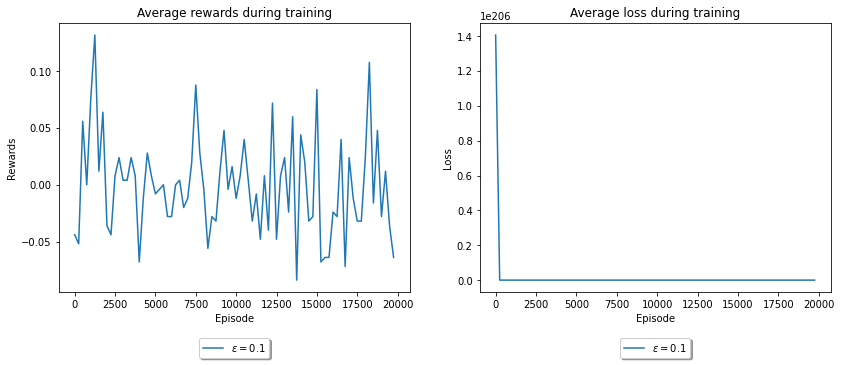

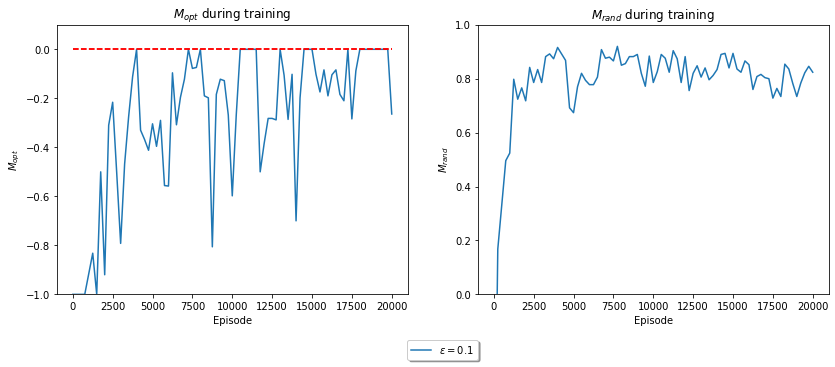

In [7]:
epsilon_exploration = 0.1
stats_dict.update({epsilon_exploration: (stats, M_opt, M_rand)})
stats_dict_list.append(stats_dict)
plot_stats(stats_dict_list, [epsilon_exploration], 'self_practice_test', '\epsilon', save=False)

### Question 16: Different values of the exploration rate $\epsilon$

In [4]:
vec_eps = np.array([0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 1])
deep_q_learning_params_list = []
var_name = "epsilon_deep_self"
for eps in vec_eps:
    params = {'env': env,
              'num_episodes': num_episodes,
              'epsilon_exploration': eps,
              'test_freq': test_freq,
              'self_practice': True}
    deep_q_learning_params_list.append(params)

In [5]:
if train:
     stats_dict_epsilon_self_list_deep = train_avg(var_name, vec_eps, deep_q_learning_params_list, dqn=True,
                                                        num_avg=num_avg, save_stats=True)

************** RUN 1 OF 1 **************
------------- Training with epsilon_deep_self = 0.0 -------------


100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [36:26<00:00,  9.14it/s]


M_opt = -1.0
M_rand = 0.14
Training with epsilon_deep_self = 0.0  took: 00h36m38s 


------------- Training with epsilon_deep_self = 0.01 -------------


 29%|██████████████████████▋                                                      | 5883/20000 [10:57<26:17,  8.95it/s]


KeyboardInterrupt: 

### Question 17: Decreasing exploration for different values of $n^*$

In [ ]:
vec_n_star = np.hstack((np.array([1, 100, 500, 750]), np.round(np.logspace(3, np.log10(40000), 16))))

In [ ]:
deep_q_learning_params_list = []
var_name = "n_star_self_deep"
for n_star in vec_n_star:
    params = {'env': env,
              'num_episodes': num_episodes,
              'epsilon_exploration_rule': return_lambda_explor(epsilon_min, epsilon_max, n_star),
              'test_freq': test_freq,
              'self_practice': True}
    deep_q_learning_params_list.append(params)

In [ ]:
if train:
    stats_dict_nstar_self_list_deep = train_avg(var_name, vec_n_star, deep_q_learning_params_list, dqn = True,
                                                     num_avg=num_avg, save_stats=True)

### Question 18: Best values of $M_{\text{opt}}$ and $M_{\text{rand}}$

In [ ]:
# TODO

### Question 19: Heatmaps of the Q-values in 3 significant states

In [ ]:
# Optimal parameters
epsilon_min = 0.1
epsilon_max = 0.8
n_star = 15000
epsilon_exploration_rule = return_lambda_explor(epsilon_min, epsilon_max, n_star)
model, stats = deep_q_learning(env, epsilon_exploration_rule=epsilon_exploration_rule, num_episodes=20000, 
                               verbose=True, against_opt=True)

In [ ]:
grids = np.array([[[1., 0., 0.], [-1., 1., 0.], [0., -1., 0.]]])
print(grids[0])
heatmaps_deep_subplots(grids, model, save=save_figs)